Egg Detection with DETR_Custom Dataset


In [1]:
# Importing libraries
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob


import torch
import torchvision.transforms as T
import torchvision
from models import build_model

/home/ncl/anaconda3/envs/kkokkobot/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = [
    'None',
    'Normal',
    'Air chamber',
    'Black egg',
    'White egg',
    'Complete Crack',
    'Straight Cr',
    'Circular Cr',
    'Updown Cr',
    'Cobweb Cr',
    'Latent Cr',
    'Fine Cr',
    'Waveform Cr',
    'Blood Spot',
    'Central Airchamber',
    'Chalaza',
    'Bubble Spot',
    'Ink pot',
    'White Spot',
    'Whitening',
    'Circular Color',
    'Thin Shell',
    'Centrall Color',
    'Updown Color',
    'Partial Color',
    'Discoloration',
    'Shell Impurity',
    'Feather Im',
    'Feces Im',
    'Spotted Im',
    'General De',
    'Severa De',
    'External De',
    'Whiteline De'
]

In [10]:
# Create arguments class for build DETR model
class Args:
    lr_backbone = 2e-4
    masks = None
    # Model parameters
    frozen_weights = None
    backbone = 'resnet50'
    dilation = False
    position_embedding = 'sine'
    enc_layers = 6
    dec_layers = 6
    dim_feedforward = 2048
    hidden_dim = 256
    dropout = 0.1
    nheads = 8
    num_queries = 100
    pre_norm = False
    aux_loss = False
    num_classes = 34
    set_cost_class=1
    set_cost_bbox=5
    set_cost_giou=2
    mask_loss_coef=1
    dice_loss_coef=1
    bbox_loss_coef=5
    giou_loss_coef=2
    eos_coef=0.1
    num_bbox_reg_classes = 2
    # Dataset parameters
    dataset_file = 'coco'
    coco_path = '/data/ttmanh/SUB_COCO/'
    remove_difficult = False
    coco_panoptic_path = None
    # Device parameters
    device = 'cuda'
    seed = 42
    # Misc
    output_dir = ''
    resume = './outputs_subclass/best.pth' # Path to load weights model


args = Args()

In [11]:
# Preprocess image - Get list of images
def collect_all_images(dir_test):
    """
    Function to return a list of image paths.

    :param dir_test: Directory containing images or single image path.

    Returns:
        test_images: List containing all image paths.
    """
    test_images = []
    if os.path.isdir(dir_test):
        image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm']
        for file_type in image_file_types:
            test_images.extend(glob.glob(f"{dir_test}/{file_type}"))
    else:
        test_images.append(dir_test)
    return test_images   

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_min, y_min, w, h = x.unbind(1)
    b = [x_min - 0.5 * w, y_min - 0.5 * h, x_min + 0.5 * w, y_min + 0.5 * h]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [12]:
# Compute distance between two points (x1, y1) and (x2, y2)
def distance(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)**0.5

# Put everything on detect function
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)
    #print(outputs)
    print(type(outputs))

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    #bboxes_scaled = bboxes_scaled.tolist()

    return probas[keep], bboxes_scaled

def Select_Bounding_Boxes(probas, bboxes_scaled):

    # Finding the center coordinates of the bounding box
    center_x = (bboxes_scaled[:, 0] + bboxes_scaled[:, 2]) / 2
    center_y = (bboxes_scaled[:, 1] + bboxes_scaled[:, 3]) / 2

    # Combine center_x and center_y to get the center coordinates
    center = torch.stack((center_x, center_y), dim=1)
    center = center.tolist()
    print(center)

    # Remove the center coordinates that are too close to each other
    dist = 0
    index_remove = []
    for i in range(len(center)):
        for j in range(i + 1, len(center)):
            dist = distance(center[i], center[j])
            if dist < 50:
                # Remove the center with the lower confidence
                if probas[i].max() > probas[j].max():
                    index_remove.append(j)
                else:
                    index_remove.append(i)

    print(index_remove)

    bboxes_scaled = bboxes_scaled.tolist()
    probas = probas.tolist()

    # Delete bounding boxes having index in index_remove
    # Sort index_remove in descending order
    index_remove.sort(reverse=True)
    # remove duplicate index
    index_remove = list(dict.fromkeys(index_remove))
    for i in index_remove:
        del bboxes_scaled[i]
        del probas[i]
    
    # Convert list to tensor
    probas = torch.tensor(probas)
    return probas, bboxes_scaled


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    pil_img = plt.imread(pil_img)
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes, COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

Detecting Eggs with DETR - DEMO with a Single Color Image


<class 'dict'>
Number bounding boxes before:  10
[[1004.3223876953125, 893.126708984375], [521.2264404296875, 887.3175048828125], [520.58837890625, 558.2183227539062], [520.1235961914062, 888.228759765625], [278.3916015625, 889.5885009765625], [279.8980712890625, 221.9292449951172], [760.8514404296875, 894.7716064453125], [763.884765625, 560.8129272460938], [1009.472412109375, 555.2072143554688], [759.8593139648438, 894.5357666015625]]
[1, 9]
Number bounding boxes after:  8


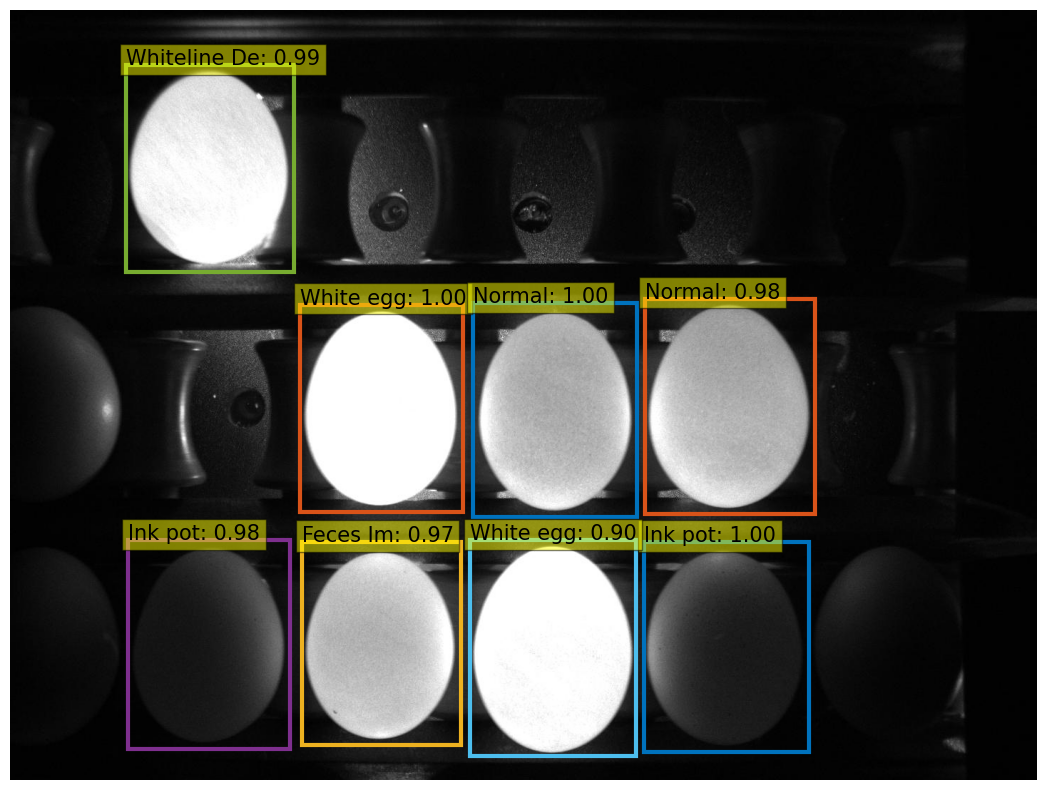

In [13]:
# Load model
model, criterion, postprocessors = build_model(args)
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

# Inference phase visualization
image = './Final_Demo_MONO/0501092348_0_00851.jpg'
img = Image.open(image)
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


scores, boxes = detect(img, model, transform)
print('Number bounding boxes before: ', len(boxes))
scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
print('Number bounding boxes after: ', len(boxes_1))
plot_results(image, scores_1, boxes_1)


Detecting Eggs with DETR - DEMO with Multiple Color Images

./Final_Demo_MONO/0502154203_1_13501.jpg
<class 'dict'>
Number bounding boxes before:  8
[[666.9908447265625, 555.7914428710938], [428.03204345703125, 556.4664306640625], [914.1722412109375, 232.81149291992188], [915.9317626953125, 231.63525390625], [1152.9462890625, 235.62875366210938], [911.6953735351562, 561.5283203125], [1151.729736328125, 562.869140625], [1153.035400390625, 235.71157836914062]]
[2, 4]
Number bounding boxes after:  6


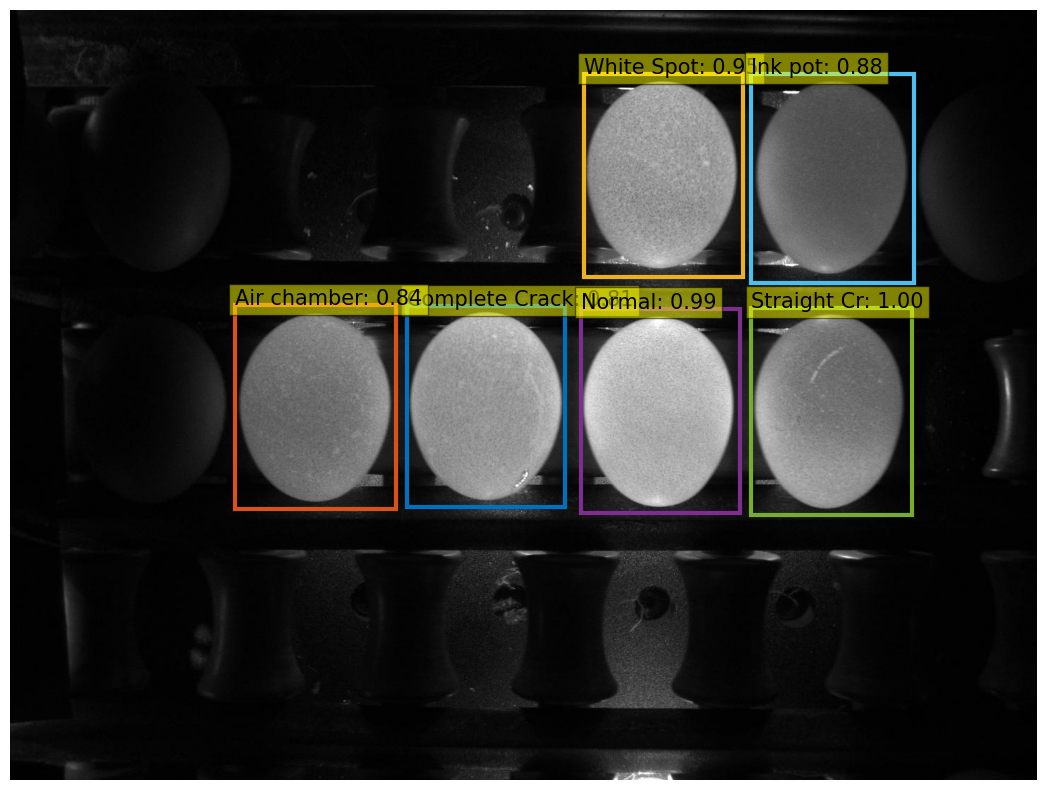

./Final_Demo_MONO/0626101856_1_07371.jpg
<class 'dict'>
Number bounding boxes before:  8
[[119.04791259765625, 526.5390014648438], [121.4942626953125, 196.1131134033203], [354.9862060546875, 197.14736938476562], [590.9525756835938, 197.80087280273438], [1072.071533203125, 537.34912109375], [349.71240234375, 527.004638671875], [838.9393310546875, 203.61839294433594], [1073.1904296875, 536.496826171875]]
[4]
Number bounding boxes after:  7


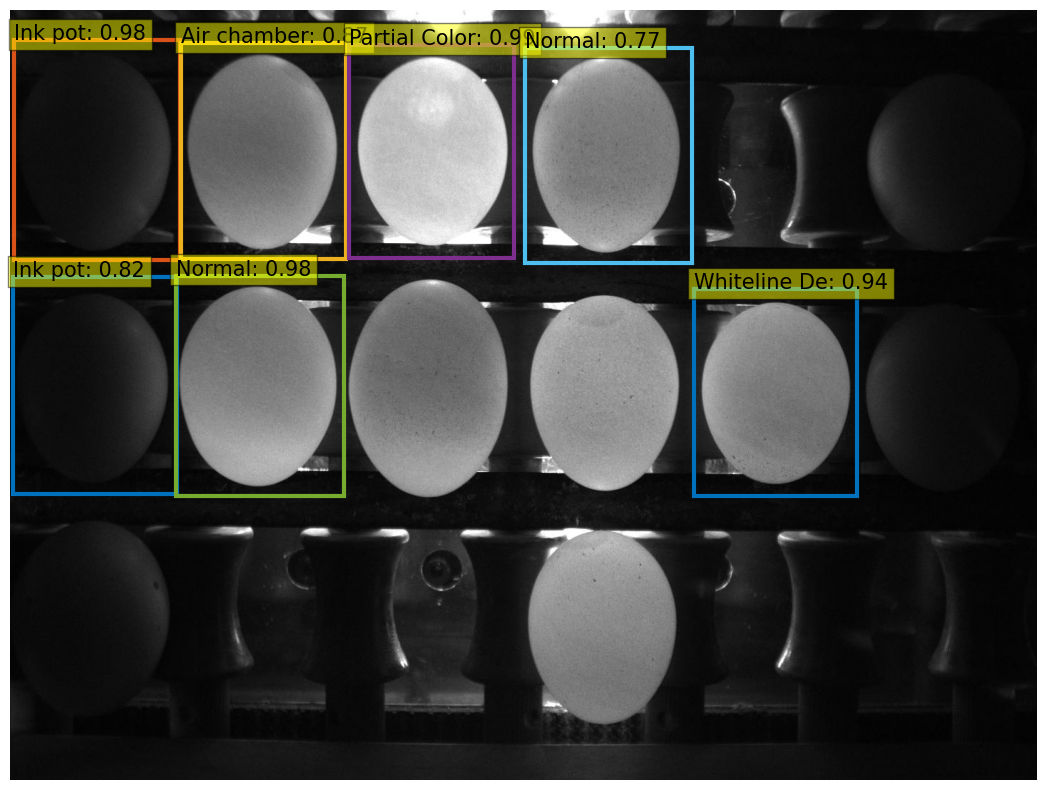

./Final_Demo_MONO/0608110848_0_07556.jpg
<class 'dict'>
Number bounding boxes before:  7
[[521.1737670898438, 569.120849609375], [1003.9954833984375, 892.546875], [519.587890625, 902.646484375], [524.120849609375, 234.8775634765625], [762.844482421875, 900.882080078125], [764.597900390625, 566.2828369140625], [1008.3291625976562, 567.5877685546875]]
[]
Number bounding boxes after:  7


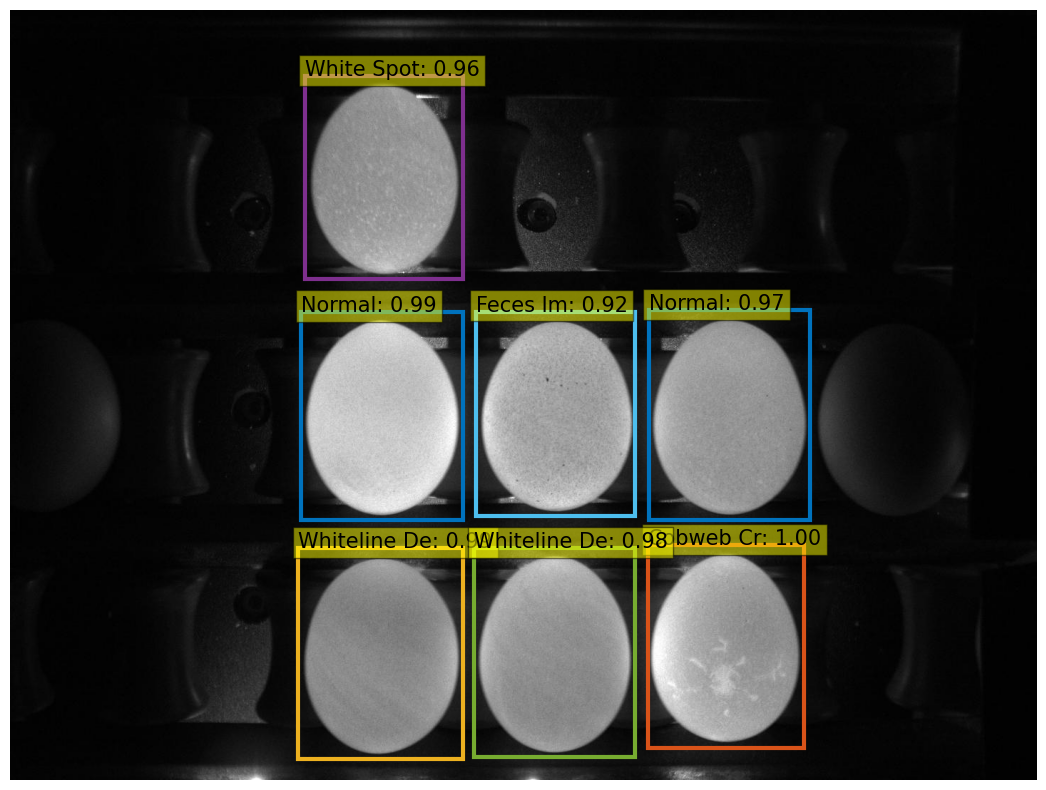

./Final_Demo_MONO/0602141706_1_10854.jpg
<class 'dict'>
Number bounding boxes before:  5
[[435.90838623046875, 885.125244140625], [444.2501220703125, 224.4326629638672], [674.3046875, 888.81396484375], [205.79859924316406, 552.8466796875], [210.8060760498047, 224.9482421875]]
[]
Number bounding boxes after:  5


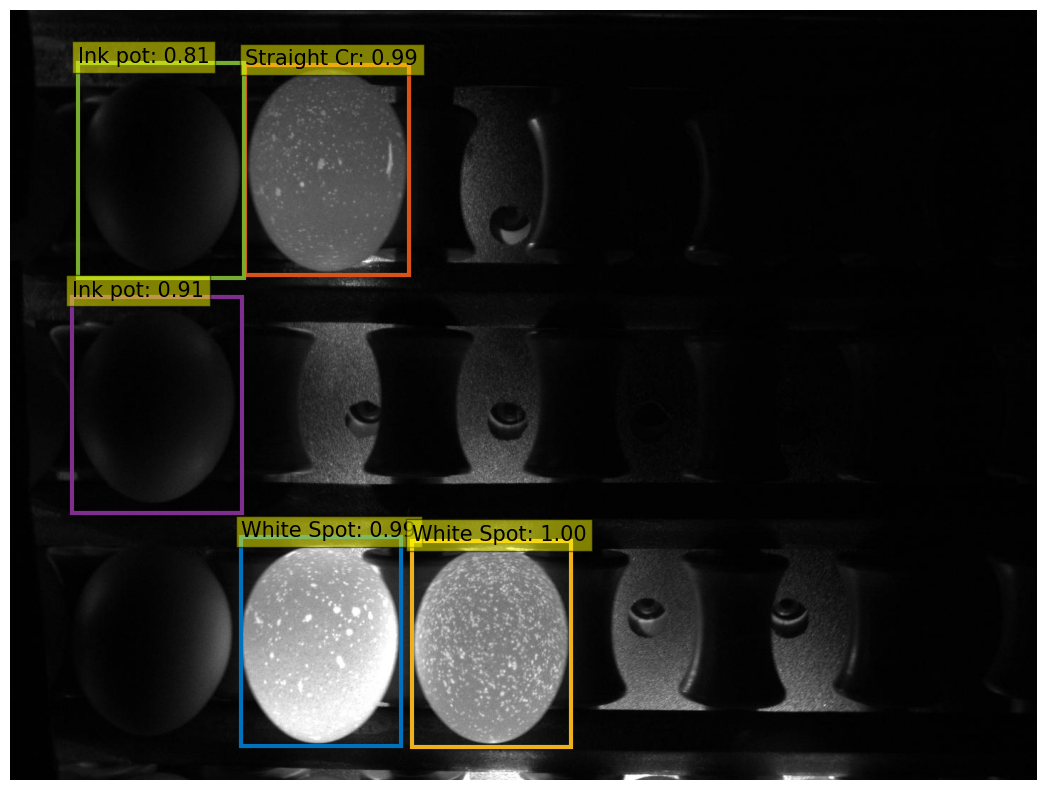

./Final_Demo_MONO/0502161411_1_15200.jpg
<class 'dict'>
Number bounding boxes before:  8
[[669.1804809570312, 556.50048828125], [429.888427734375, 233.90866088867188], [673.65771484375, 228.96556091308594], [426.08685302734375, 555.4175415039062], [914.9471435546875, 229.99810791015625], [1152.0369873046875, 232.0188751220703], [912.6771240234375, 556.5966796875], [1151.1668701171875, 234.05307006835938]]
[7]
Number bounding boxes after:  7


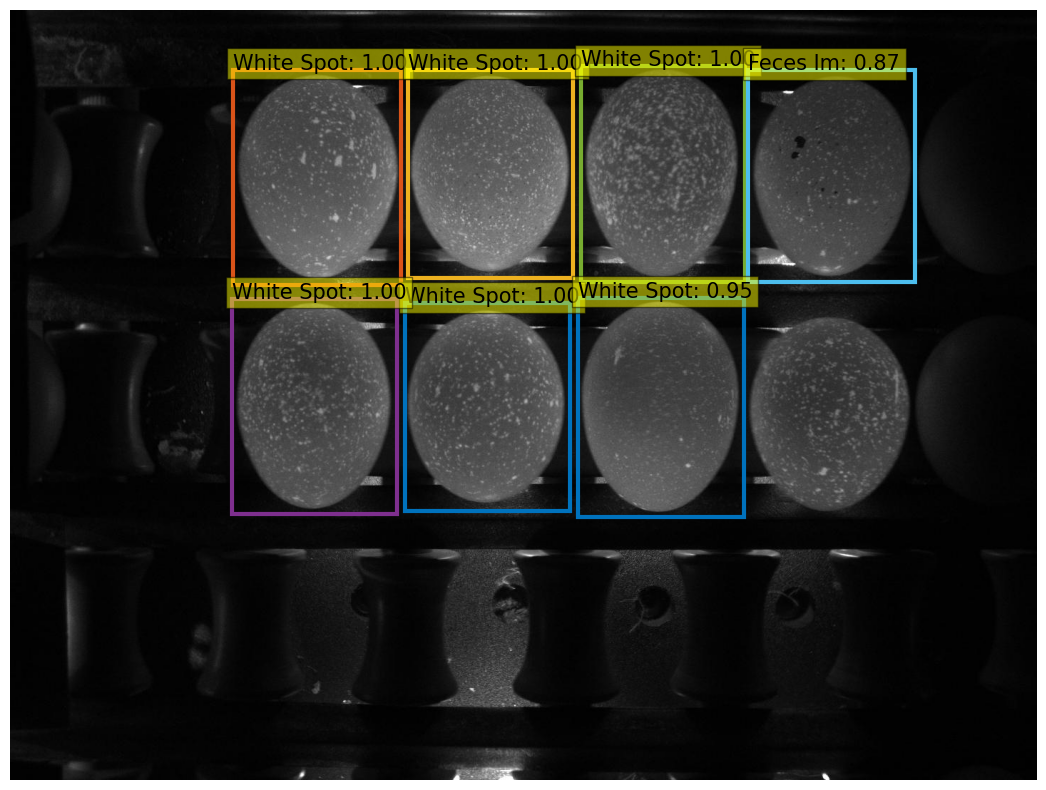

./Final_Demo_MONO/0605112239_0_06360.jpg
<class 'dict'>
Number bounding boxes before:  5
[[765.6419677734375, 561.705078125], [280.97369384765625, 226.16041564941406], [766.6298217773438, 226.12181091308594], [284.0805358886719, 895.685546875], [1012.0974731445312, 227.7940216064453]]
[]
Number bounding boxes after:  5


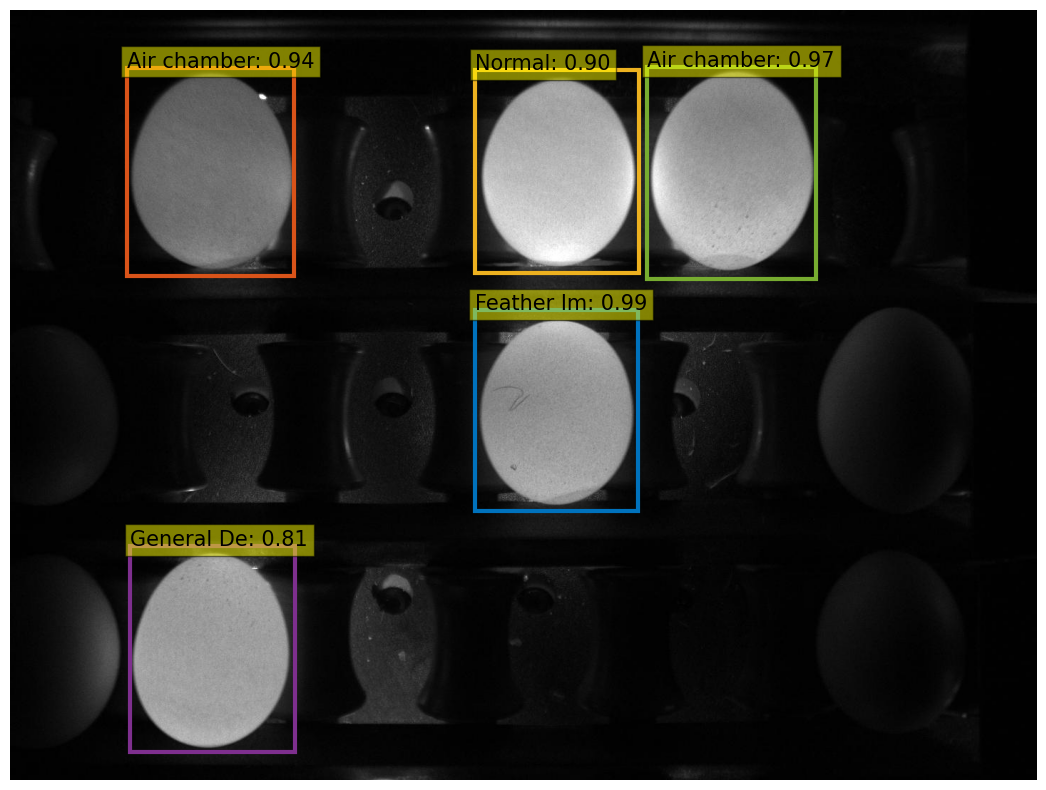

./Final_Demo_MONO/0531154014_0_11478.jpg
<class 'dict'>
Number bounding boxes before:  12
[[520.5313110351562, 558.5150146484375], [280.41766357421875, 560.3382568359375], [1001.708984375, 883.8485107421875], [520.7406005859375, 888.451416015625], [767.219970703125, 226.6979522705078], [280.623779296875, 227.26666259765625], [521.8919677734375, 558.1552734375], [523.1489868164062, 225.71945190429688], [1005.963134765625, 557.1866455078125], [521.8123779296875, 889.151123046875], [523.7556762695312, 226.81117248535156], [765.7120361328125, 560.9075317382812]]
[0, 9, 7]
Number bounding boxes after:  9


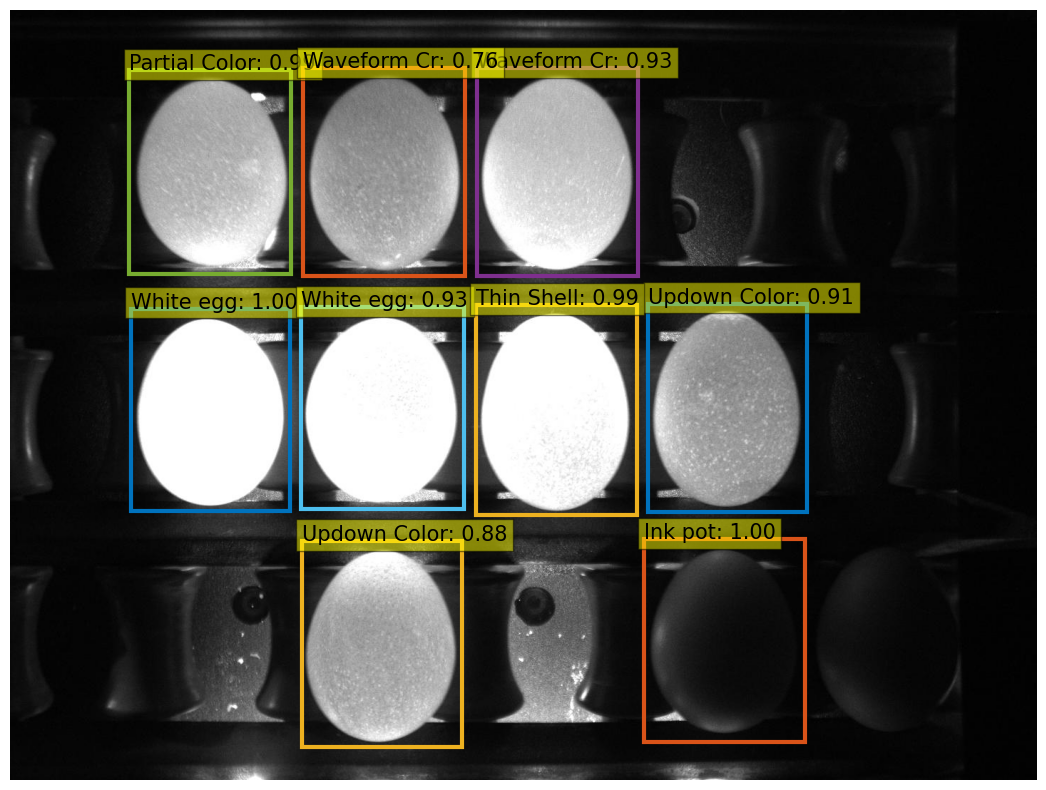

./Final_Demo_MONO/0501094852_0_02741.jpg
<class 'dict'>
Number bounding boxes before:  9
[[763.826416015625, 568.2169189453125], [1005.1632690429688, 892.1834716796875], [284.6034851074219, 227.15382385253906], [522.4403076171875, 892.5637817382812], [280.80902099609375, 892.3096313476562], [1009.4342041015625, 228.5609130859375], [764.2943115234375, 567.0692749023438], [1010.02099609375, 565.7921142578125], [762.307861328125, 897.7737426757812]]
[0]
Number bounding boxes after:  8


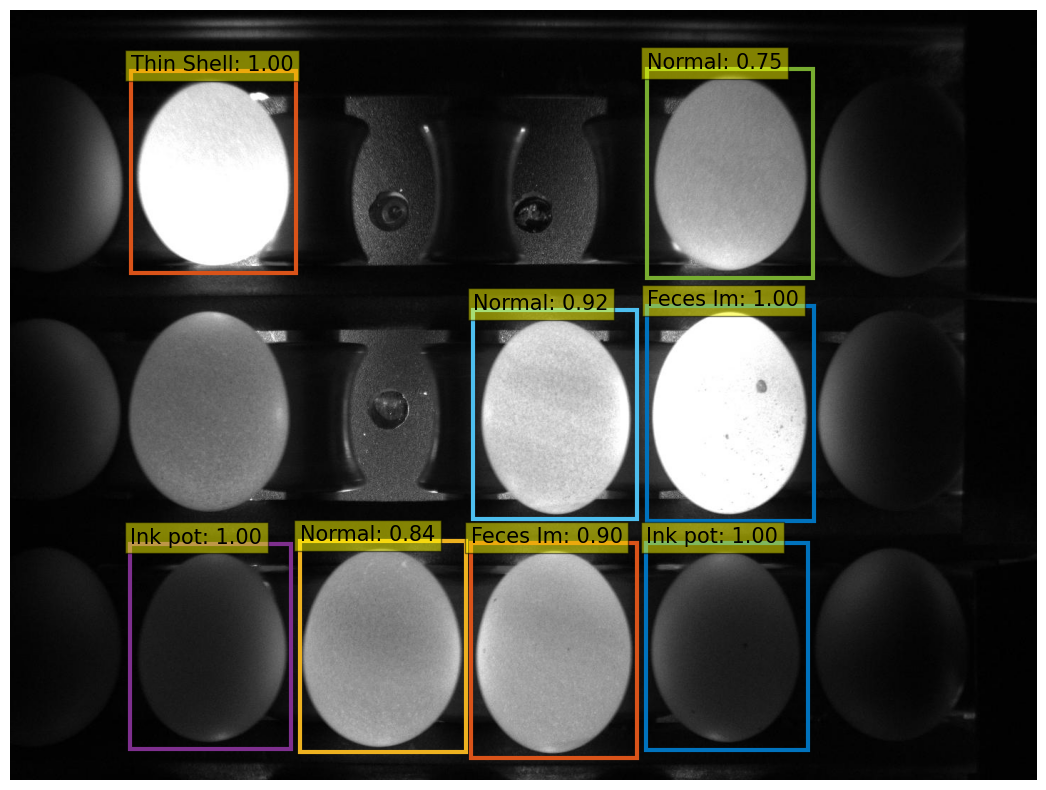

./Final_Demo_MONO/0502100935_0_04796.jpg
<class 'dict'>
Number bounding boxes before:  10
[[1007.3411254882812, 885.914794921875], [524.98974609375, 894.1758422851562], [523.0404052734375, 894.5901489257812], [283.8672180175781, 562.5714721679688], [285.36517333984375, 891.0550537109375], [766.1907348632812, 896.0933837890625], [1013.8242797851562, 229.29815673828125], [767.874267578125, 560.8438110351562], [1012.683837890625, 559.5339965820312], [765.7982177734375, 894.929931640625]]
[1, 5]
Number bounding boxes after:  8


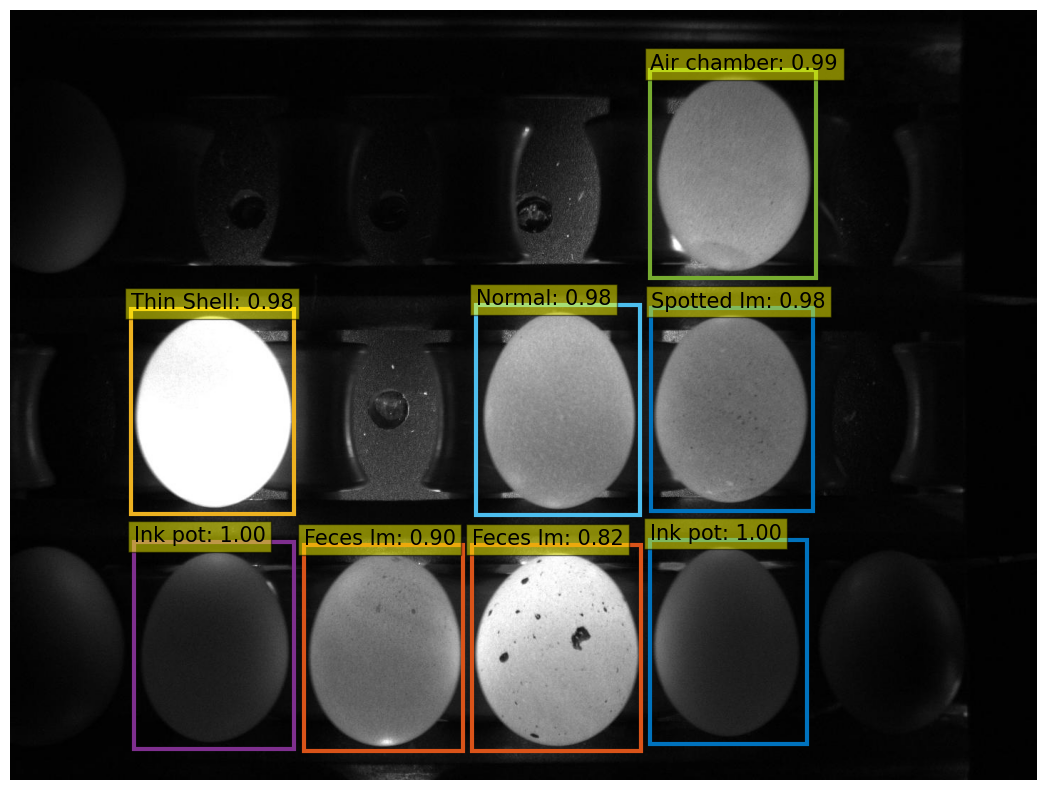

./Final_Demo_MONO/0605120916_0_09821.jpg
<class 'dict'>
Number bounding boxes before:  6
[[278.43511962890625, 886.2491455078125], [519.141845703125, 559.5828857421875], [519.6481323242188, 893.4578857421875], [1004.859130859375, 561.4500732421875], [1005.1139526367188, 226.87118530273438], [763.0252685546875, 561.5048828125]]
[]
Number bounding boxes after:  6


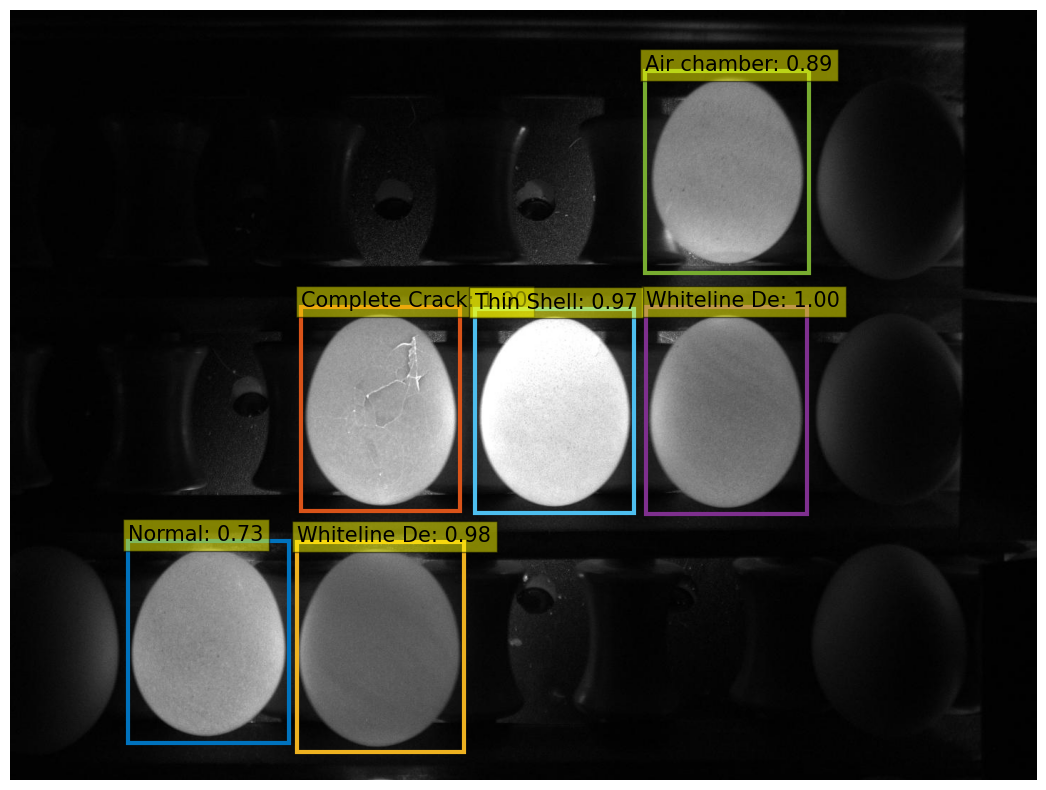

In [14]:
DIR_TEST = './Final_Demo_MONO/'
test_images = collect_all_images(DIR_TEST)

count = 0

for image in test_images:
    if (count == 10):
        break
    #Print out the image name
    print(image)
    img = Image.open(image)

    scores, boxes = detect(img, model, transform)
    print('Number bounding boxes before: ', len(boxes))
    scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
    print('Number bounding boxes after: ', len(boxes_1))
    plot_results(image, scores_1, boxes_1)
    count += 1

Compute mAP for the Test Dataset - MONO Dataset with 6 classes

In [ ]:
# Move the evaluation file for COLOR and rename file
# Prepare COLOR evaluation file outside and move it to the directory datasets/coco_eval.py
# Delete the original coco_eval.py file
!mv ./datasets/coco_eval.py ./datasets/coco_eval_original.py
!cp -r ./coco_eval_mono.py ./datasets/
!mv ./datasets/coco_eval_mono.py ./datasets/coco_eval.py


In [ ]:
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate
from torch.utils.data import DataLoader
import util.misc as utils

dataset_test = build_dataset(image_set='test', args=args)
sampler_test = torch.utils.data.SequentialSampler(dataset_test)

data_loader_test = DataLoader(dataset_test, args.batch_size, sampler=sampler_test,
                                 drop_last=False, collate_fn=utils.collate_fn, num_workers=2)


# Evaluate
model = model.to(args.device)
base_ds = get_coco_api_from_dataset(dataset_test)


test_stats, coco_evaluator = evaluate(model, criterion, postprocessors, data_loader_test, base_ds, args.device, args.output_dir)